In [52]:
#Import important libraries
import numpy as np
import pandas as pd
import warnings
import ast

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import RegexpTokenizer
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import re
import scipy
from lightfm import LightFM
from scipy.sparse import csr_matrix

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)

In [18]:
# Import dataset
user_data = pd.read_csv('../input/input-data/consumer_transanctions.csv')
content_data = pd.read_csv('../input/input-data/platform_content.csv')

#### EDA on Data

In [19]:
print(user_data.shape)
user_data.head()

(72312, 8)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.24 Safari/537.36",NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [20]:
# Check null values to decide necessary columns
user_data.isnull().sum()/len(user_data)

event_timestamp         0.000000
interaction_type        0.000000
item_id                 0.000000
consumer_id             0.000000
consumer_session_id     0.000000
consumer_device_info    0.212883
consumer_location       0.213035
country                 0.212883
dtype: float64

In [21]:
# Lets check the country wise distribution
user_data['country'].value_counts()/len(user_data)

# Since majority data is between only 3 countries, lets not include it in analysis

BR    0.710753
US    0.064401
KR    0.003305
CA    0.003125
JP    0.001991
AU    0.001908
GB    0.000304
DE    0.000263
IE    0.000194
IS    0.000180
ZZ    0.000152
SG    0.000152
AR    0.000097
PT    0.000083
ES    0.000041
IN    0.000041
IT    0.000028
MY    0.000028
CL    0.000014
CN    0.000014
CH    0.000014
NL    0.000014
CO    0.000014
Name: country, dtype: float64

In [22]:
# Interaction Type
user_data['interaction_type'].value_counts()/len(user_data)

content_watched         0.844756
content_liked           0.079447
content_saved           0.034061
content_commented_on    0.022278
content_followed        0.019457
Name: interaction_type, dtype: float64

In [23]:
# Final column selection
# consumerid, itemid and event_type
user_data_final = user_data[['consumer_id','item_id','interaction_type']]
print(user_data_final.shape)
user_data_final.head()

(72312, 3)


,consumer_id,item_id,interaction_type
0,-8845298781299428018,-3499919498720038879,content_watched
1,-1032019229384696495,8890720798209849691,content_watched
2,-1130272294246983140,310515487419366995,content_watched
3,344280948527967603,310515487419366995,content_followed
4,-445337111692715325,-7820640624231356730,content_watched


In [24]:
# Exploring the content data

print(content_data.shape)
content_data.head()

(3122, 13)


event_timestamp    interaction_type              item_id  \
0       1459192779  content_pulled_out -6451309518266745024   
1       1459193988     content_present -4110354420726924665   
2       1459194146     content_present -7292285110016212249   
3       1459194474     content_present -6151852268067518688   
4       1459194497     content_present  2448026894306402386   

           producer_id  producer_session_id producer_device_info  \
0  4340306774493623681  8940341205206233829                  NaN   
1  4340306774493623681  8940341205206233829                  NaN   
2  4340306774493623681  8940341205206233829                  NaN   
3  3891637997717104548 -1457532940883382585                  NaN   
4  4340306774493623681  8940341205206233829                  NaN   

  producer_location producer_country item_type  \
0               NaN              NaN      HTML   
1               NaN              NaN      HTML   
2               NaN              NaN      HTML   
3               NaN              NaN      HTML   
4               NaN              NaN      HTML   

                                                                                                                        item_url  \
0  http://www.nytimes.com/2016/03/28/business/dealbook/ethereum-a-virtual-currency-enables-transactions-that-rival-bitcoins.html   
1  http://www.nytimes.com/2016/03/28/business/dealbook/ethereum-a-virtual-currency-enables-transactions-that-rival-bitcoins.html   
2                                http://cointelegraph.com/news/bitcoin-future-when-gbpcoin-of-branson-wins-over-usdcoin-of-trump   
3                                                  https://cloudplatform.googleblog.com/2016/03/Google-Data-Center-360-Tour.html   
4                    https://bitcoinmagazine.com/articles/ibm-wants-to-evolve-the-internet-with-blockchain-technology-1459189322   

                                                                     title  \
0  Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's   
1  Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's   
2       Bitcoin Future: When GBPcoin of Branson Wins Over USDcoin of Trump   
3                                             Google Data Center 360° Tour   
4            IBM Wants to "Evolve the Internet" With Blockchain Technology   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [25]:
# Check the different types of event
content_data['interaction_type'].value_counts()/len(content_data)

content_present       0.975977
content_pulled_out    0.024023
Name: interaction_type, dtype: float64

In [26]:
content_data['language'].value_counts()/len(content_data)

en    0.725176
pt    0.272261
la    0.001281
es    0.000641
ja    0.000641
Name: language, dtype: float64

In [27]:
# We need to remove the content that is being pulled out because we cant recommend it to anyone
content_data = content_data[content_data['interaction_type']=='content_present']
content_data.shape


(3047, 13)

In [28]:
# Final content data
content_data_final = content_data[['item_id','title','text_description']].drop_duplicates()
print(content_data_final.shape)
content_data_final.head()

(3047, 3)


item_id  \
1 -4110354420726924665   
2 -7292285110016212249   
3 -6151852268067518688   
4  2448026894306402386   
5 -2826566343807132236   

                                                                     title  \
1  Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's   
2       Bitcoin Future: When GBPcoin of Branson Wins Over USDcoin of Trump   
3                                             Google Data Center 360° Tour   
4            IBM Wants to "Evolve the Internet" With Blockchain Technology   
5         IEEE to Talk Blockchain at Cloud Computing Oxford-Con - CoinDesk   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [29]:
# Join the two datasets on item_id to create a master dataset
recommend_data = pd.merge(user_data_final,content_data_final, on = ['item_id'],how = 'inner')
print(recommend_data.shape)
recommend_data.head()

(72269, 5)


,consumer_id,item_id,interaction_type,title,text_description
0,-8845298781299428018,-3499919498720038879,content_watched,Hiri wants to fix the workplace email problem,"Hiri is the latest startup trying to fix email. Specifically, the Dublin-based company is targeting workplace email with an array of features that aim to nudge users to change their email behaviour for the better. For it isn't email that is necessarily broken but the way we all use and abuse it. Starting with the premise that thoughtless and un-targeted emails fill a very high percentage of your work email inbox, Hiri's headline feature is the ability for recipients to rate each email they receive, which serves as the basis for your own email score or email analytics. You've given a weekly score based on feedback received relating to clarity, brevity, and tone, and the software's rating of your overall email behaviour. The idea, the startup's CEO and co-founder Kevin Kavanagh told me during a call last week, is to get employees thinking about how they currently use email and to begin to change their behaviour for the better. The weekly score also ensures employees don't return to bad email habits. Citing research from the UK's University of Loughborough that found the average employee spends 2.5 hours a day on their work email and checks its 96 times a day, which equates to every five minutes, Kavanagh says that most employees would benefit greatly from checking email less. That's because not only is email a time sinker in itself but the time it takes to recover from having your flow interrupted also adds up. This is probably most extreme for tasks where intense concentration and getting 'in the zone' is paramount, such as coding. Hiri's second and blunter tool prevents you checking email too often. You are made to wait 30 minutes between inbox visits. However, my favourite feature of Hiri is the way it asks you to explicitly separate emails you send into two groups. Ones that are just an FYI, and ones that require further action. It's a very simple idea but one that I think could be incredibly effective. An unspoken rule of the workplace is that people routinely loop colleagues and superiors into emails so that if the shit hits the fan they can always share or evade responsibility. That's created an explosion in email, making it easy to miss those that are task-related. Hiri's simple categorisation feature, which actually renames the CC field, aims to fix this. Emails you send with Hiri can be labeled as requiring an action, which automatically creates a task for the main recipient(s), a question, or as an FYI. You can also drag and drop any email you receive into your task list. And when composing an email you are asked to write a subject line last. The thinking here is that writing a subject line is easier and makes more sense after you've actually written what you wanted to say in the body of the email. Of course, the startup's biggest challenge is going to be penetrating the enterprise, since Hiri needs to be installed right across the workplace for it to be truly useful. That's something Kavanagh concedes but says the company is tackling on three fronts. Firstly, Hiri is essentially an email client, compatible with MS Exchange and MS Office 365. In other words, it doesn't replace a company's existing email infrastructure. Secondly, the startup has developed a neat Outlook plugin that measures the amount of time that employees spend on email. The idea is that a company can install this before adopting Hiri to see how bad the problem is first. The plugin also captures the number of times that employees switch from other applications to check their mail. Lastly, the modestly funded Hiri has some decent backers who no doubt can help open doors in the enterprise. They include a Global Director of Facebook and an EMEA Director of LinkedIn. And most recently, the startup picked up a $1 million seed round from Delta Partners, ACT Venture Capital, and Enterprise Ir

2979


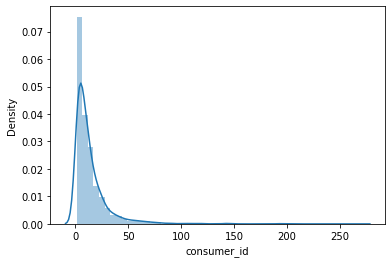

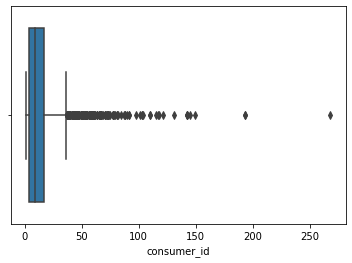

In [30]:
# Filter the items that are read by atleast 5 users
print(recommend_data['item_id'].drop_duplicates().count())
item_data = recommend_data.groupby('item_id').agg({'consumer_id':'nunique'}).reset_index()

sns.distplot(item_data['consumer_id'])
plt.show()
sns.boxplot(item_data['consumer_id'])
plt.show()

In [31]:
# It can be clearly seen that there is skewness in the data
# There are certain articles which are read by soo many users
# In order to normalise it, lets consider only those articles which are read by aleast 5 people and at max 100 people
item_data = item_data[(item_data['consumer_id']>=5) & (item_data['consumer_id']<=100)]
print(item_data.shape)

(2087, 2)


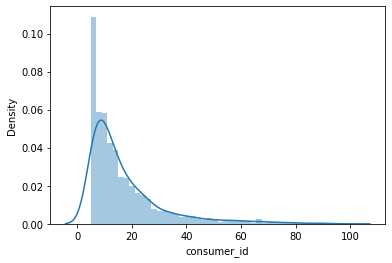

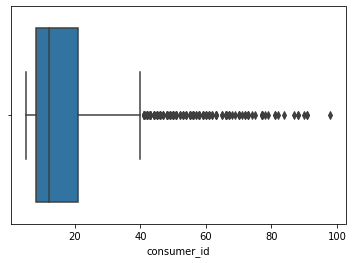

In [32]:
# Check the distribution now
sns.distplot(item_data['consumer_id'])
plt.show()
sns.boxplot(item_data['consumer_id'])
plt.show()

In [33]:
# Join the item dataset back to the recommendor datastet to get the master dataset
recommend_data_final = pd.merge(recommend_data,item_data,on = ['item_id'],how = 'inner')
print(recommend_data.shape)
print(recommend_data_final.shape)

(72269, 5)
(64076, 6)


In [34]:
# Create a unique list of text descriptions and title
text_df_unique = recommend_data_final[['item_id','text_description','title']].drop_duplicates()
print(text_df_unique.shape)

(2087, 3)


In [35]:
# Text Cleaning
def remove_numerical(s):
    l = s.split(" ")
    words = []
    for w in l:
        if(re.search("[A-Za-z]",w)==None):
            pass
        else:
            words.append(w)
    text = " ".join(words)
    return text

def stemming(s):
    sb = SnowballStemmer(language = 'english')
    l = s.split(" ")
    words = []
    for w in l:
        words.append(sb.stem(w))
    text = " ".join(words)
    return text
            

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words(["english",'portuguese']))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text



text_df_unique['cleaned_description'] = text_df_unique['text_description'].apply(make_lower_case)
text_df_unique['cleaned_description'] = text_df_unique['cleaned_description'].apply(remove_numerical)
text_df_unique['cleaned_description'] = text_df_unique['cleaned_description'].apply(remove_stop_words)
text_df_unique['cleaned_description'] = text_df_unique['cleaned_description'].apply(stemming)
text_df_unique['cleaned_description'] = text_df_unique['cleaned_description'].apply(remove_punctuation)

10000


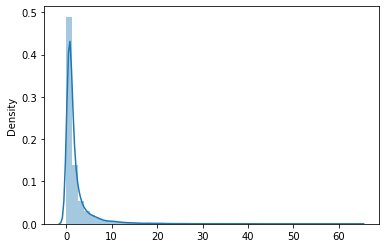

In [36]:
# Start text processing
# Pre process using basic methods
tfidf = TfidfVectorizer(max_features = 10000)   
tfidf_fit=tfidf.fit_transform(text_df_unique['cleaned_description'])    
word_list = tfidf.get_feature_names();    
count_list = tfidf_fit.toarray().sum(axis=0) 
print(len(count_list))
sns.distplot(count_list)
vec_array = tfidf_fit.toarray()

In [37]:
text_df_unique['Text_Vectors'] = list(vec_array)
text_df_unique.head()

item_id  \
0   -3499919498720038879   
20   8890720798209849691   
170   310515487419366995   
306 -7820640624231356730   
317 -8864073373672512525   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

#### Content Based Filtering

In [38]:
# Function to give top n recommendations
def simi_fun(v1,v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    simi = np.dot(v1,v2)/((np.linalg.norm(v1)*np.linalg.norm(v2)))
    return simi
    


def recommend_content(title,n):
    title = title.lower()
    title_vec = text_df_unique[text_df_unique['title'].str.lower()==title][['Text_Vectors']]
    title_vec.columns = ['Title_Vector']
    title_vec['key'] = 1
    text_df_unique['key'] = 1
    content_recommender = pd.merge(text_df_unique,title_vec,on = ['key'],how = 'inner').drop('key',axis = 1).reset_index(drop = True)
    content_recommender['similarity'] = content_recommender[['Text_Vectors','Title_Vector']].apply(lambda x:simi_fun(x[0],x[1]),axis = 1)
    content_recommender = content_recommender[content_recommender['similarity']<0.99]
    content_recommender = content_recommender[['title','similarity']].sort_values(by  = 'similarity',ascending = False).reset_index(drop = True)
    content_recommender = content_recommender.iloc[0:n,:]
    return content_recommender
    

In [39]:
content_recommender_df = recommend_content('Inbox by Gmail: a better way to keep track of events, newsletters and links',10)
content_recommender_df

,title,similarity
0,Hiri wants to fix the workplace email problem,0.270978
1,Bots won't replace apps. Better apps will replace apps.,0.215648
2,AI Is Here to Help You Write Emails People Will Actually Read,0.214977
3,20 Percent Will Stop Reading Your Email If You Make This One Mistake,0.212321
4,Measuring email effectiveness in retail banking,0.164002
5,Making email safer with new security warnings in Gmail,0.163973
6,"Stream processing, Event sourcing, Reactive, CEP... and making sense of it all",0.163890
7,"What do you mean by ""Event-Driven""?",0.158139
8,10 Simple Habits of Insanely Productive People,0.143067
9,Communication patterns in a Microservice world,0.138333


### Create User Item Matrix
### Give Weightage Based on Interaction

In [40]:
# Create User Interaction subset from x
# Join 'text_df_unique' and above subset on item_id
consumer_df_subset = recommend_data[['consumer_id','item_id','interaction_type']].drop_duplicates().reset_index(drop = True)
content_weight_dict  = {'content_watched':1,'content_liked':2,'content_saved':3,'content_followed':4,'content_commented_on':5}
consumer_df_subset['content_weight'] = consumer_df_subset['interaction_type'].map(content_weight_dict)

user_content_df = pd.merge(consumer_df_subset,text_df_unique, on = 'item_id',how = 'inner')
user_content_df_v2 = user_content_df[['consumer_id', 'content_weight','item_id']].drop_duplicates().reset_index(drop = True)
user_content_df_v2.head()

,consumer_id,content_weight,item_id
0,-8845298781299428018,1,-3499919498720038879
1,-108842214936804958,1,-3499919498720038879
2,-1443636648652872475,1,-3499919498720038879
3,-8020832670974472349,1,-3499919498720038879
4,-9009798162809551896,2,-3499919498720038879


In [41]:
# Creating the Matrix
user_content_df_final = user_content_df_v2.pivot_table(index = 'consumer_id',columns = ['item_id'],values ='content_weight' )
user_content_df_final = user_content_df_final.fillna(0)
print(user_content_df_final.shape)
user_content_df_final.head()

(1819, 2087)


item_id               -9222795471790223670  -9216926795620865886  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   1.5   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9194572880052200111  -9192549002213406534  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9189659052158407108  -9176143510534135851  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9161596996229760398  -9160910454530522563  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9137036168156595470  -9128741757954228992  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9128652074338368262  -9102431381393428051  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9090514312860140897  -9089854794058353436  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9086955082453789880  -9083294960368598209  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9081753261356157170  -9076501258717815738  \
consumer_id                                                        
-9223121837663643404                   0.0      

### Implement ALS

In [42]:
sparse_mat = sparse.csr_matrix(np.array(user_content_df_final))
def implicit_als(sparse_data, alpha_val=40, iterations=10, lambda_val=0.1, features=10):
    """
    Implementation of Alternating Least Squares with implicit data. We iteratively
    compute the user (x_u) and item (y_i) vectors using the following formulas:
 
    x_u = ((Y.T*Y + Y.T*(Cu - I) * Y) + lambda*I)^-1 * (X.T * Cu * p(u))
    y_i = ((X.T*X + X.T*(Ci - I) * X) + lambda*I)^-1 * (Y.T * Ci * p(i))
 
    Args:
        sparse_data (csr_matrix): Our sparse user-by-item matrix
 
        alpha_val (int): The rate in which we'll increase our confidence
        in a preference with more interactions.
 
        iterations (int): How many times we alternate between fixing and 
        updating our user and item vectors
 
        lambda_val (float): Regularization value
 
        features (int): How many latent features we want to compute.
    
    Returns:     
        X (csr_matrix): user vectors of size users-by-features
        
        Y (csr_matrix): item vectors of size items-by-features
    """

    # Calculate the foncidence for each value in our data
    confidence = sparse_data * alpha_val
    
    # Get the size of user rows and item columns
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users-by-features, the item vectors
    # Y of size items-by-features and randomly assign the values.
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size = (item_size, features)))
    
    #Precompute I and lambda * I
    X_I = sparse.eye(user_size)
    Y_I = sparse.eye(item_size)
    
    I = sparse.eye(features)
    lI = lambda_val * I
    for i in range(iterations):
        print ('iteration %d of %d' % (i+1, iterations))
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)

        # Loop through all users
        for u in range(user_size):

            # Get the user row.
            u_row = confidence[u,:].toarray() 

            # Calculate the binary preference p(u)
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0

            # Calculate Cu and Cu - I
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I

            # Put it all together and compute the final formula
            yT_CuI_y = Y.T.dot(CuI).dot(Y)
            yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)

    
        for i in range(item_size):

            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()

            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0

            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I

            # Put it all together and compute the final formula
            xT_CiI_x = X.T.dot(CiI).dot(X)
            xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)

    return X, Y

In [43]:
# Calling ALS
user_vecs, item_vecs = implicit_als(sparse_mat, iterations=10, features=20, alpha_val=40)

iteration 1 of 10
iteration 2 of 10
iteration 3 of 10
iteration 4 of 10
iteration 5 of 10
iteration 6 of 10
iteration 7 of 10
iteration 8 of 10
iteration 9 of 10
iteration 10 of 10


In [44]:
# Creating User DF and Item DF
user_df = pd.DataFrame(user_vecs.toarray(),columns = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20'],index = user_content_df_final.index ).reset_index()
print(user_df.shape)
item_df = pd.DataFrame(item_vecs.toarray(),columns = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20'],index = user_content_df_final.columns ).reset_index()
print(item_df.shape)


(1819, 21)
(2087, 21)


In [45]:
#------------------------------
# FIND SIMILAR ITEMS
#------------------------------


# Note that this ID might be different for you if you're using
# the full dataset or if you've sliced it somehow. 
item_id = -3499919498720038879
n = 10

item_df['Item_Vec'] = list(np.array(item_df.drop('item_id',axis = 1)))
item_vec = item_df[item_df['item_id']==item_id][['Item_Vec']].reset_index(drop = True)
item_vec.columns = ['Item_Find_Vec']
item_df['key'] = 1
item_vec['key'] = 1
content_recommender = pd.merge(item_df,item_vec,on = ['key'],how = 'inner').drop('key',axis = 1).reset_index(drop = True)
content_recommender['similarity'] = content_recommender[['Item_Vec','Item_Find_Vec']].apply(lambda x:simi_fun(x[0],x[1]),axis = 1)
content_recommender = content_recommender[content_recommender['similarity']<0.99]
content_recommender = content_recommender[['item_id','similarity']].sort_values(by  = 'similarity',ascending = False).reset_index(drop = True)
content_recommender = content_recommender.iloc[0:n,:]
content_recommender

# Can be mapped to the Item name easily    

,item_id,similarity
0,-6380034335041404646,0.965262
1,7804826445069770894,0.964266
2,4241385837165861843,0.938065
3,-8800029253812071912,0.934113
4,6669026579073415958,0.930233
5,8527071648070448758,0.920364
6,1339353160969606996,0.919976
7,65053321054180411,0.918392
8,1440793148901830221,0.915780
9,-89955207814154444,0.914104


In [46]:
# Let's say we want to recommend artists for user with ID 2023
user_id = -9223121837663643404
n = 10
#------------------------------
# GET SIMILAR USERS FOR A GIVEN USERS
#------------------------------

# Find the top 10 users 

user_df['User_Vec'] = list(np.array(user_df.drop('consumer_id',axis = 1)))
user_vec = user_df[user_df['consumer_id']==user_id][['User_Vec']].reset_index(drop = True)
user_vec.columns = ['User_Find_Vec']
user_df['key'] = 1
user_vec['key'] = 1
content_recommender = pd.merge(user_df,user_vec,on = ['key'],how = 'inner').drop('key',axis = 1).reset_index(drop = True)
content_recommender['similarity'] = content_recommender[['User_Vec','User_Find_Vec']].apply(lambda x:simi_fun(x[0],x[1]),axis = 1)
content_recommender = content_recommender[content_recommender['similarity']<0.99]
content_recommender = content_recommender[['consumer_id','similarity']].sort_values(by  = 'similarity',ascending = False).reset_index(drop = True)
content_recommender = content_recommender.iloc[0:n,:]
content_recommender

,consumer_id,similarity
0,7192340689726207788,0.664598
1,-9172914609055320039,0.644691
2,7316935598591113280,0.595578
3,8243474948679935093,0.587470
4,116117092134318174,0.576825
5,1056179711361543558,0.574173
6,-2708048174260028189,0.571948
7,3499125955852759846,0.568041
8,6354670420844196172,0.567703
9,4795304184119033503,0.565898


### Hybrid Recommender

In [65]:
user_content_interaction_csr = csr_matrix(user_content_df_final.values)
user_content_interaction_csr
user_id = list(user_content_df_final.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
    
item_id = list(user_content_df_final.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

    

In [68]:
# Build Model
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)
model = model.fit(user_content_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=True)



Epoch: 100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


In [88]:
# Recommendation Function
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    known_items = scores[0:nrec_items]
    known_items = list(pd.Series(known_items))
    if show == True:
        print ("User: " + str(user_id))
        print("Recommended Items")
        return pd.Series(known_items)
        

In [95]:
# Make Predicttions
item_series  = pd.DataFrame(sample_recommendation_user(model, user_content_df_final, 7192340689726207788, user_dict, item_dict),columns = ['item_id'])
item_df = pd.merge(item_series,content_data_final,on = 'item_id',how = 'inner').drop('text_description',axis = 1)
item_df


User: 7192340689726207788
Recommended Items


,item_id,title
0,2203293143157288172,"Por falta de seguro, Alex e Marquinhos não participam de treino da seleção"
1,1805789466376069146,Setting Up HTTP(S) Load Balancing
2,-8762137947059829459,"Google I/O 2016: Develop, Grow & Earn"
3,3256054536066714292,Google moves to replace Flash with HTML5
4,5439554346835640135,"Consórcio: Venda de novas cotas cai 13,5% no 1º trimestre"
5,5271898714958115766,This Tiny Robot Lets You Play God With Huge AI
6,3385087622593663739,Captain Fantastic (2016)
7,-3739000323288188282,Why Uber Is Killing the Bank (And What That Means for Everything Else)
8,6999813113145211708,Write Like You Talk
9,-8412113620940365599,The best-and worst-places to be a working woman


### Model Evaluation
### Using AUC Score

In [106]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model, user_content_interaction_csr).mean()
print('AUC Score:-',train_auc)


AUC Score:- 0.57573885
